In [3]:
import numpy as np
from matplotlib import pyplot as plt

Satellite images are normally stored in formats such as GeoTIFF or NetCDF but here, to avoid importing extra libraries, we have saved a Modis satellite image locally using a numpy specific format .npz. We can load this file into a numpy array by doing

In [4]:
arr_modis = np.load("data/modis_cube.npz")["nadir"]

arr_modis.shape

(2400, 2400, 7)

This file contains a composite image taken by the MODIS Terra and Acqua satellites over an 8-day period. The image correspond to the area of southwest France and north of Spain around mid July 2018. Each pixel has a resolution of 500 meters and there are 7 spectral bands: [red, near infra-red (nir), blue, green, short-wave infra-red (swir) 1, swir2, swir3]

Let's plot one band (0 -> red) to have quick look at the region

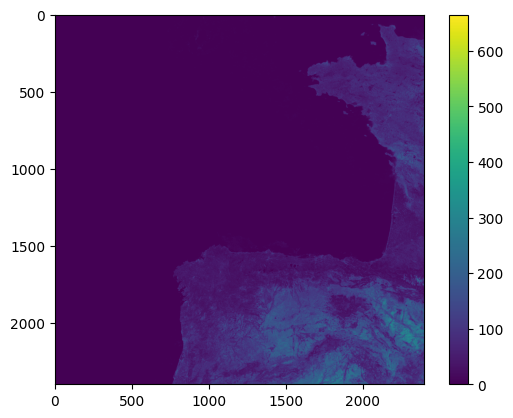

In [6]:
plt.imshow(arr_modis[:, :, 0])
plt.colorbar()

The MODIS data represents reflectance values (reflected/incident proportion) for each spectral band. Reflectance is a measure that indicates the proportion of the energy at each part of the spectrum that is reflected by the Earth at each spectral band. The values are therefore in the range [0-1]. 0 represent pixel with no reflection (all energy is being absorbed) and 1 represents all energy is reflected.

These values need to be stored as floating point numbers but to save space is a common practice to use 2-bytes integers (int16 vs float32) and then rescale dividing by a large number.

Before we can interpret these images we need to convert the stored values into reflectance values [0-1.0]. To do this conversion for Modis data we use a conversion factor of 10,000. (In Python you can use scientific notation in which 1e4 == 1*10^4 == 10,000)

To scale the values into reflectance values we can perform this operation which applies the division along the whole array element-wise (remember broadcasting):

In [9]:
refl_modis = arr_modis / 1e4

print("Min:", arr_modis.min(), "Max:", arr_modis.max())
print("Data type:", arr_modis.dtype)
print("-----------------")
print("Min:", refl_modis.min(), "Max:", refl_modis.max())
print("Data type:", refl_modis.dtype)

Min: 0 Max: 753
Data type: int16
-----------------
Min: 0.0 Max: 0.0753
Data type: float64


As we can see, numpy automatically converts the values in the array from integers into floats to performs the division.
Now we are going to create a true colour composite, creating an image by selecting the red, green and blue components of the multispectral image.

In [10]:
rgb_modis = refl_modis[:,:,[0,3,2]]

rgb_modis.min(), rgb_modis.max()

(0.0, 0.0665)

Only ~6% of the incident light gets reflected in this image. So we are going to rescale this image and make its dynamic range span the [0,1] interval.

In [11]:
rgb_modis = rgb_modis / rgb_modis.max()

rgb_modis.min(), rgb_modis.max()

(0.0, 1.0)

In [12]:
rgb_modis.shape

(2400, 2400, 3)

Now lets plot the RGB image using matplotlib's imshow function.

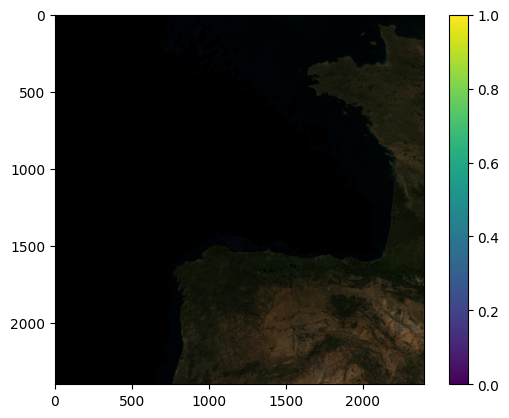

In [14]:
plt.imshow(rgb_modis)
plt.colorbar()

The previous image is a bit dark and it's hard to see the details in it. To improve its contrast we are going to expand the dynamic range of the lower values in the image by multiplying the array by 3. By doing this, we will lose, or clip, that larger values in the image but will get an improved representation of the lower values to visually assess the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


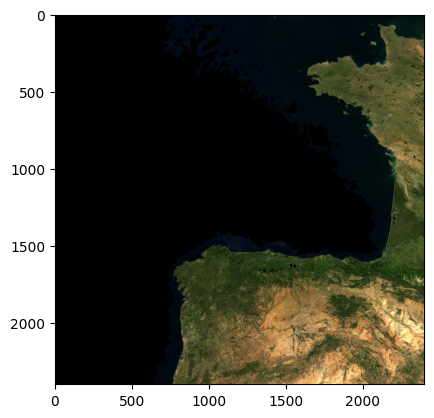

In [18]:
plt.imshow(rgb_modis*3)

The previous image is called natural colour because it maps the RGB channels of the image to the red, green and blue. Chainging the order of the bands we can map bands of the satellite to the RGB channels differently, also including other bands outside the visible. The images resulting from alternative mapping between RGB and spectral channels are commonly known as 'false coulour'.

Exercise 3.3: Similarly to the previous image, can you generate a false colour image mapping MODIS near-infrared band into the images' red channel?

In [19]:
nirgb_modis = refl_modis[:,:,[1,3,2]]

In [20]:
nirgb_modis = nirgb_modis / nirgb_modis.max()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


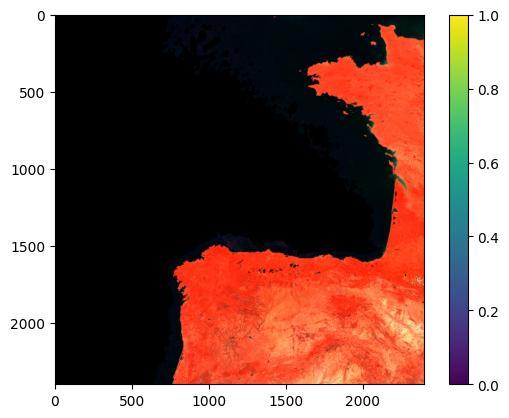

In [22]:
plt.imshow(nirgb_modis*3)
plt.colorbar()

Mapping the near infrared (nir) channel to the red colour we produces an image showing bright red in regions with more vegetation. Different combinations of reflectance bands are used to look at different properties of the land surface.

Exercise 3.4: Try different mappings between MODIS' spectral bands and the RGB channels in the following cell.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


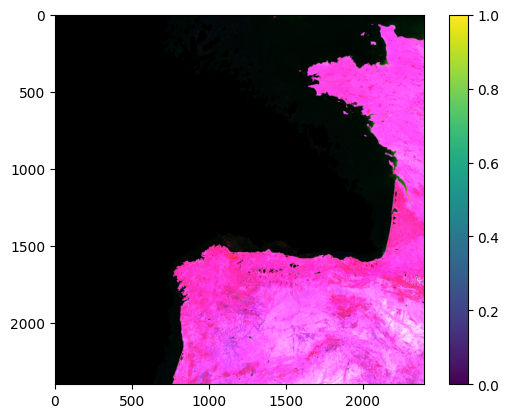

In [29]:
spectral_rgb_modis = refl_modis[:,:,[1,3,5]]
spectral_rgb_modis = spectral_rgb_modis / spectral_rgb_modis.max()
plt.imshow(spectral_rgb_modis*3)
plt.colorbar()

These images using colour composites offer useful visual representations of remote sensing data. Another common way to represent and analyse these images is through the use of normalised indices. These indices are normally computed using two or more spectral bands into a normalised [-1,1] range. There are multiple well-known normalising algorithms used to detect fire scars, water but probably the most famous one is the Normalised Difference Vegetation Index (NDVI) which shows live vegetation.

## NDVI=(NIR-Red)/(NIR+Red)
This operation can be performed in numpy using a very similar notation using arrays:

In [39]:
ndvi_modis = (refl_modis[:,:,1]-refl_modis[:,:,0]) / (refl_modis[:,:,1]+refl_modis[:,:,0])

"Shape:", ndvi_modis.shape, "Max:", np.nanmax(ndvi_modis), "Min:", np.nanmin(ndvi_modis)

/tmp/ipykernel_63474/2764322337.py:1: RuntimeWarning: invalid value encountered in divide
  ndvi_modis = (refl_modis[:,:,1]-refl_modis[:,:,0]) / (refl_modis[:,:,1]+refl_modis[:,:,0])


('Shape:', (2400, 2400), 'Max:', 1.0, 'Min:', -1.0)

As opposed to the previous false/true colour images, normalised indices contain just one band. To represent the values in the array we'll need to use a predefined colour palette to map the values into different colours.
We can pass the imshow function a parameter to specify the color map to use for our NDVI index. We use summer_r, which goes from yellow to green, to represent vegetation in the image. Here you can find a list of the colour maps available.

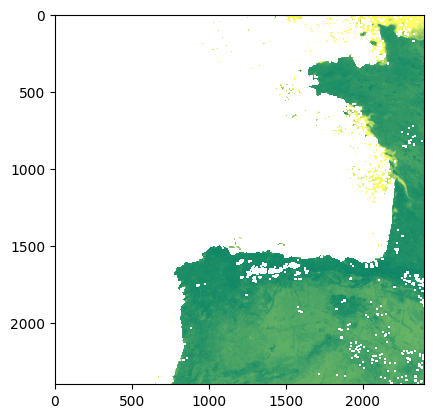

In [40]:
#To make vegetation look green in the image we apply a colour palette that goes from yellow to green.
plt.imshow(ndvi_modis, cmap='summer_r')

We can adjust how the values are mapped into the colours in the palette by providing the maximum and minimum values to the imshow function. This is useful to plot certain ranges and enhance where vegetation is in an image. For example:

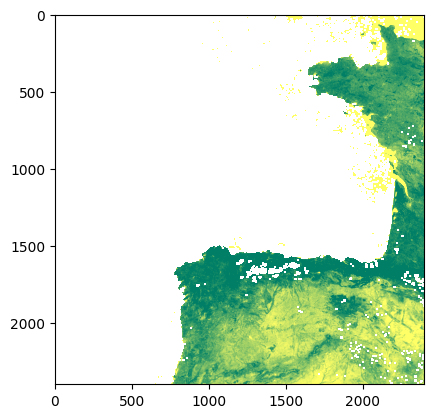

In [41]:
plt.imshow(ndvi_modis, vmin=.2, vmax=.8, cmap='summer_r')

Another normalised index is used to monitor changes related to water content in water bodies, using green and NIR wavelengths, defined by McFeeters (1996):

## NDWI=(Green-NIR)/(Green+NIR)
Exercise 3.5: Can you calculate the NDWI array for the previous image?

/tmp/ipykernel_63474/1126191562.py:1: RuntimeWarning: invalid value encountered in divide
  ndwi_modis = (refl_modis[:,:,3]-refl_modis[:,:,1]) / (refl_modis[:,:,3]+refl_modis[:,:,1])


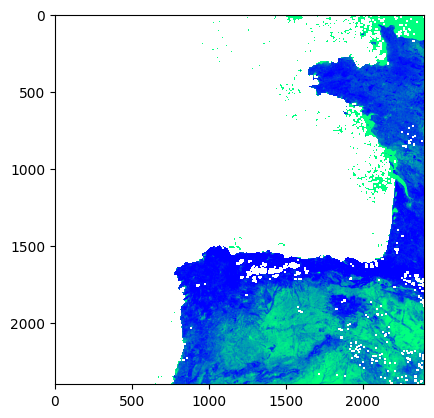

In [43]:
ndwi_modis = (refl_modis[:,:,3]-refl_modis[:,:,1]) / (refl_modis[:,:,3]+refl_modis[:,:,1])

plt.imshow(ndvi_modis, vmin=.2, vmax=.8, cmap='winter_r')

Exercise 3.6: Can you use slice indexing [:, :] to select and region and plot a zoomed-in area of the previous image?

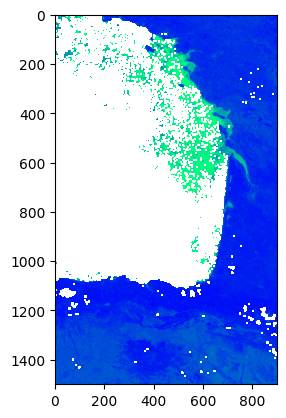

In [45]:
plt.imshow(ndvi_modis[500:2000,1500:2400], cmap='winter_r')

MODIS generates multi-spectral images. When the number of spectral bands is large, we call those images hyperspectral. The following dataset contains hyperspectral images collected from an airplane in February 2014 as it passed over the Australian National University.
High-resolution hyper-spectral data tends to make very large files. To make processing in this tutorial easier, we have packed a numpy array with the just the [red, nir, green, blue] bands. This array is 3-dimensional with the third dimension corresponding to the spectral bands, just like the MODIS data. Let's start by loading the data:

('Shape:', (482, 521, 4))

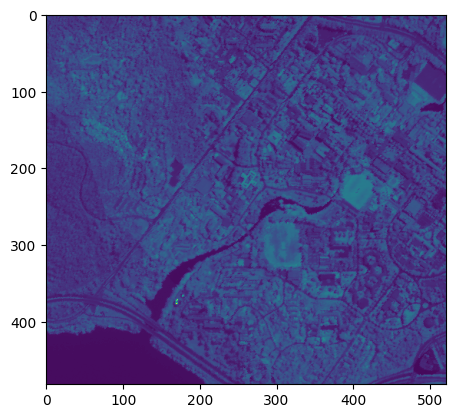

In [46]:
arr_anu = np.load("data/anu_cube.npz")["array"]
refl_anu = arr_anu/1e4

plt.imshow(refl_anu[:,:,1])

"Shape:", refl_anu.shape

Exercise 3.7: Can you calculate the NDVI index for this image following similar steps to the previous MODIS example?

In [48]:
ndvi_anu = (refl_anu[:, :, 1] - refl_anu[:, :, 0])/(refl_anu[:, :, 1] + refl_anu[:, :, 0])

/tmp/ipykernel_63474/2637412413.py:1: RuntimeWarning: invalid value encountered in divide
  ndvi_anu = (refl_anu[:, :, 1] - refl_anu[:, :, 0])/(refl_anu[:, :, 1] + refl_anu[:, :, 0])


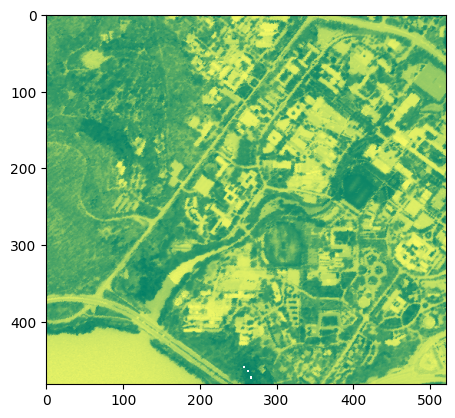

In [50]:
plt.imshow(ndvi_anu, cmap='summer_r')

Similar to NDVI, there is another index called Green Colour Coordinate (GCC), which is an alternative method to NDVI for looking at how green vegetation is. This one does not use the near-infrared band, which is serves as a convenient alternative for sensors that only generate red, green and blue.

## GCC = Green / (Red+Green+Blue)

/tmp/ipykernel_63474/2886231601.py:1: RuntimeWarning: invalid value encountered in divide
  gcc_anu = refl_anu[:,:,2]/(refl_anu[:,:,0]+refl_anu[:,:,2]+refl_anu[:,:,3])


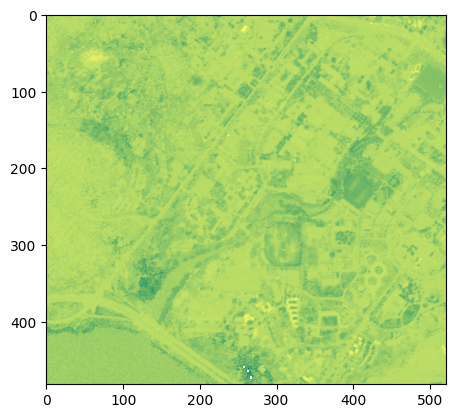

In [51]:
gcc_anu = refl_anu[:,:,2]/(refl_anu[:,:,0]+refl_anu[:,:,2]+refl_anu[:,:,3])

plt.imshow(gcc_anu, cmap='summer_r')

Let's do some classification generating a series of boolean arrays for different ranges of these vegetation indices. We define the following three categories.

    Class 1: NDVI equal or greater than 0.5 and GCC greater than 0.4 indicates green, vegetated surfaces.
    Class 2: NDVI less than 0.5 and GCC greater than 0.4 indicates surfaces that look green but are not vegetated.
    Class 3: NDVI more than 0.5 and GCC less or equal than 0.4 indicates vegetated surfaces that don't look green. 

In [52]:
c1 = (ndvi_anu >= 0.5) * (gcc_anu >= 0.4)
c2 = (ndvi_anu < 0.5) * (gcc_anu >= 0.4)
c3 = (ndvi_anu >= 0.5) * (gcc_anu < 0.4)

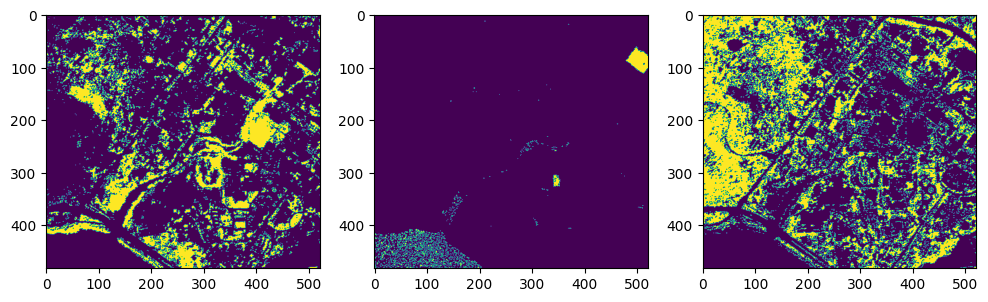

In [58]:
fig, ax = plt.subplots(1, 3, figsize = (12, 12))
ax[0].imshow(c1)
ax[1].imshow(c2)
ax[2].imshow(c3)

imshow can also create binary representations of boolean arrays.
Now we want to stack these three categorical or boolean arrays into a 3-dimensional array to be able to plot a RGB composite image. Numpy's dstack function stacks 2-dimensional arrays along the third axis, referred as 'depth' so the prefix 'd' in the name.

In [59]:
class_comp = np.dstack((c1,c2,c3))

class_comp.shape, class_comp.dtype

((482, 521, 3), dtype('bool'))

Now, to be able to generate the RGB image from this image we need to convert it into either uint8 with range [0-255] or into float32 with range [0-1].

Exercise 3.8: Can you convert the type of the class_comp array into float32?

Now we can use imshow to plot the RGB representation of these three classes. Remeber C1 is mapped to red, C2, into green and C3 to blue.

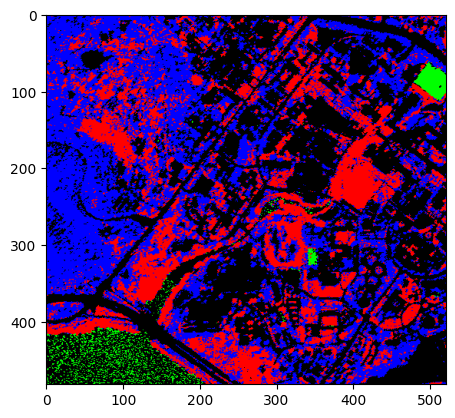

In [61]:
plt.imshow(class_comp.astype('float32'))

You will see this leaves a fourth class in the image, of pixels that fall in none of the three classes. They show up in black. There are two surfaces that show up 'green' and one area that shows mixed black and blue bits. What are they?

This simple classification uses index thresholds, which is a crude but sometimes useful way of classifying images. In this case, it helps to finding unvegetated green surfaces, such as tennis courts and artificial grass. It is also clear that greenish water confounds the classification, however.

Exercise 3.9: Can you try to compute a similar classification image using the previous Modis image?


In [63]:
gcc_modis = refl_modis[:,:,2]/(refl_modis[:,:,0]+refl_modis[:,:,2]+refl_modis[:,:,3])

c1_modis = (ndvi_modis >= 0.5) * (gcc_modis >= 0.4)
c2_modis = (ndvi_modis < 0.5) * (gcc_modis >= 0.4)
c3_modis = (ndvi_modis >= 0.5) * (gcc_modis < 0.4)

/tmp/ipykernel_63474/2262278092.py:1: RuntimeWarning: invalid value encountered in divide
  gcc_modis = refl_modis[:,:,2]/(refl_modis[:,:,0]+refl_modis[:,:,2]+refl_modis[:,:,3])


In [64]:
class_comp_modis = np.dstack((c1_modis,c2_modis,c3_modis))

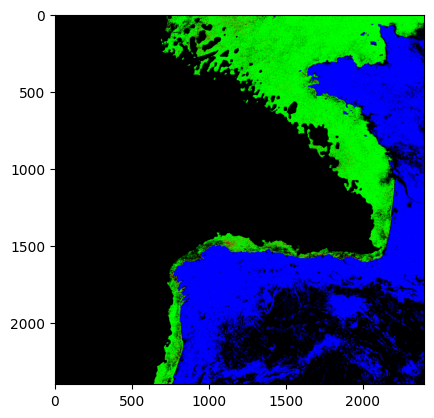

In [65]:
plt.imshow(class_comp_modis.astype('float32'))